In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

import kerastuner as kt

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils

<Figure size 432x288 with 0 Axes>

In [2]:
main_path = '/home/rfradkin/xom/'
raw_tess_path = '/scratch/data/tess/lcur/spoc/raws/'
tess_metad_path = '/data/scratch/data/tess/meta/'
xom_data_path = '/data/scratch/data/moon/'

#### GPU Setup

In [3]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 94% |
|  1 |  0% | 10% |
|  2 |  0% | 10% |
|  3 |  0% | 10% |


In [14]:
# Specific GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1:4], 'GPU')
mirror_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


#### Data Preprocessing

In [42]:
datas = 'padde_cuts-1_1-parti-1637036581.5612013.pkl'

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

In [43]:
numbe_sampl = -1

# Create a shuffled sample of the data
rando_shuff_x_data = raw_x_data[utils.retur_rando_sampl(
    numbe_sampl, len(raw_x_data))]
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1]['plane_cut_injec'] ###

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

29.85% of the dataset contains a full injection


In [44]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test_np = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [45]:
# Mask the data
masking = layers.Masking(mask_value=0., input_shape = (1900, 1))

x_train_unmas = tf.convert_to_tensor(x_train_np)
x_test_unmas = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)
x_train = masking(x_train_unmas)
x_test = masking(x_test_unmas)

#### Training

In [11]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{dataset}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience=3)
resto_valid_accur = utils.resto_best_valid_accur()

callb = [resto_valid_accur, early_stopp]#, tensorboard]

In [12]:
log_direc = f'{xom_data_path}keras_tuner/{datas}_{float(time.time())}'


def tuner_model(hyper):

    model = keras.Sequential()

    lstm_gru = hyper.Choice('LSTM/GRU', ['LSTM', 'GRU'])
    if lstm_gru == 'LSTM':
        numbe_lstm = hyper.Int('numbe lstm layers', 1, 3)
        if numbe_lstm == 1 and not initi:
            model.add(
                layers.LSTM(hyper.Int('lstm 1 units', 32, 256, 16),
                            input_shape=(1900, 1),
                            activation='tanh'))
        else:
            model.add(
                layers.LSTM(hyper.Int('lstm 1 units', 32, 256, 16),
                            input_shape=(1900, 1),
                            activation='tanh',
                            return_sequences=True))
        if numbe_lstm == 2:
            model.add(
                layers.LSTM(hyper.Int('lstm 2 units', 32, 256, 16),
                            activation='tanh'))
        elif numbe_lstm == 3 or initi:
            model.add(
                layers.LSTM(hyper.Int('lstm 2 units', 32, 256, 16),
                            activation='tanh',
                            return_sequences=True))
            if initi:
                model.add(
                    layers.LSTM(hyper.Int('lstm 3 units', 32, 256, 16),
                                activation='tanh',
                                return_sequences=True))
            else:
                model.add(
                    layers.LSTM(hyper.Int('lstm 3 units', 32, 256, 16),
                                activation='tanh'))

    if lstm_gru == 'GRU' or initi:
        numbe_gru = hyper.Int('numbe gru layers', 1, 3)
        if numbe_gru == 1 and not initi:
            model.add(
                layers.GRU(hyper.Int('gru 1 units', 32, 256, 16),
                           input_shape=(1900, 1),
                           activation='tanh'))
        else:
            model.add(
                layers.GRU(hyper.Int('gru 1 units', 32, 256, 16),
                           input_shape=(1900, 1),
                           activation='tanh',
                           return_sequences=True))
        if numbe_gru == 2:
            model.add(
                layers.GRU(hyper.Int('gru 2 units', 32, 256, 16),
                           activation='tanh'))
        elif numbe_gru == 3 or initi:
            model.add(
                layers.GRU(hyper.Int('gru 2 units', 32, 256, 16),
                           activation='tanh',
                           return_sequences=True))
            model.add(
                layers.GRU(hyper.Int('gru 3 units', 32, 256, 16),
                           activation='tanh'))

    numbe_dense = hyper.Int('numbe dense layers', 2, 6)
    elu_tanh_PReLU1 = hyper.Choice('elu/tanh/PreLU 1',
                                   ['elu', 'tanh', 'PReLU'])
    model.add(
        layers.Dense(hyper.Int(f'dense 1', 16, 256, 16),
                     activation=elu_tanh_PReLU1))
    model.add(layers.Dropout(hyper.Float('float dropout 1', 0, .9)))

    if numbe_dense >= 2 or initi:
        elu_tanh_PReLU2 = hyper.Choice('elu/tanh/PreLU 2',
                                       ['elu', 'tanh', 'PReLU'])
        model.add(
            layers.Dense(hyper.Int(f'dense 2', 16, 256, 16),
                         activation=elu_tanh_PReLU2))
        model.add(layers.Dropout(hyper.Float('float dropout 2', 0, .9)))
    if numbe_dense >= 3 or initi:
        elu_tanh_PReLU3 = hyper.Choice('elu/tanh/PreLU 3',
                                       ['elu', 'tanh', 'PReLU'])
        model.add(
            layers.Dense(hyper.Int(f'dense 3', 16, 256, 16),
                         activation=elu_tanh_PReLU3))
        model.add(layers.Dropout(hyper.Float('float dropout 3', 0, .9)))
    if numbe_dense >= 4 or initi:
        elu_tanh_PReLU4 = hyper.Choice('elu/tanh/PreLU 4',
                                       ['elu', 'tanh', 'PReLU'])
        model.add(
            layers.Dense(hyper.Int(f'dense 4', 16, 256, 16),
                         activation=elu_tanh_PReLU4))
        model.add(layers.Dropout(hyper.Float('float dropout 4', 0, .9)))
    if numbe_dense >= 5 or initi:
        elu_tanh_PReLU5 = hyper.Choice('elu/tanh/PreLU 5',
                                       ['elu', 'tanh', 'PReLU'])
        model.add(
            layers.Dense(hyper.Int(f'dense 5', 16, 256, 16),
                         activation=elu_tanh_PReLU5))
        model.add(layers.Dropout(hyper.Float('float dropout 5', 0, .9)))
    if numbe_dense >= 6 or initi:
        elu_tanh_PReLU6 = hyper.Choice('elu/tanh/PreLU 6',
                                       ['elu', 'tanh', 'PReLU'])
        model.add(
            layers.Dense(hyper.Int(f'dense 6', 16, 256, 16),
                         activation=elu_tanh_PReLU6))
        model.add(layers.Dropout(hyper.Float('float dropout 6', 0, .9)))

    model.add(layers.Dense(1, activation='sigmoid'))

    clipnorm_val = hyper.Float('clipnorm value', 0.1, 0.9)
    lr = hyper.Float('learning rate', 1e-6, 1e-2)
    dr = hyper.Float('decay rate', 1e-6, 1e-2)

    opt = tf.keras.optimizers.Nadam(learning_rate=lr,
                                    decay=dr,
                                    clipnorm=clipnorm_val)

    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [15]:
initi = True
tuner = kt.BayesianOptimization(hypermodel=tuner_model,
                                objective='val_accuracy',
                                max_trials=15,
                                executions_per_trial=1,
                                distribution_strategy=mirror_strat,
                                directory=log_direc,
                                project_name='Exomoon RNN')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [16]:
initi = False
tuner.search(x_train,
             y_train,
             verbose=2,
             epochs=10,
             batch_size=100,
             callbacks=callb,
             validation_data=(x_test, y_test))

Trial 15 Complete [00h 02m 03s]
val_accuracy: 0.7547297477722168

Best val_accuracy So Far: 0.8668919205665588
Total elapsed time: 00h 35m 28s
INFO:tensorflow:Oracle triggered exit


In [17]:
utils.send_task_comple_email('KT')

In [53]:
tuner.get_best_hyperparameters()[0].values

{'LSTM/GRU': 'GRU',
 'numbe lstm layers': 1,
 'lstm 1 units': 112,
 'lstm 2 units': 256,
 'lstm 3 units': 256,
 'numbe gru layers': 2,
 'gru 1 units': 32,
 'gru 2 units': 32,
 'gru 3 units': 32,
 'numbe dense layers': 2,
 'elu/tanh/PreLU 1': 'elu',
 'dense 1': 160,
 'float dropout 1': 0.33617004292600355,
 'elu/tanh/PreLU 2': 'PReLU',
 'dense 2': 256,
 'float dropout 2': 0.0,
 'elu/tanh/PreLU 3': 'PReLU',
 'dense 3': 256,
 'float dropout 3': 0.0,
 'elu/tanh/PreLU 4': 'PReLU',
 'dense 4': 16,
 'float dropout 4': 0.9,
 'elu/tanh/PreLU 5': 'elu',
 'dense 5': 16,
 'float dropout 5': 0.9,
 'elu/tanh/PreLU 6': 'PReLU',
 'dense 6': 16,
 'float dropout 6': 0.4698570221299397,
 'clipnorm value': 0.8237373497157694,
 'learning rate': 0.01,
 'decay rate': 0.002302444442203369}

In [28]:
model = tuner.get_best_models(num_models=1)[0]

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1900, 32)          3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 160)               5280      
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               41472     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [54]:
opt = tf.keras.optimizers.Nadam(learning_rate=3e-4,
                                clipnorm=0.8237373497157694)

In [55]:
model.compile(loss='BinaryCrossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [56]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    callbacks=callb,
                    validation_data=(x_test, y_test))

Epoch 1/10
518/518 [==============================] - 99s 164ms/step - loss: 0.3533 - accuracy: 0.8706 - val_loss: 0.3379 - val_accuracy: 0.8802
Epoch 2/10
518/518 [==============================] - 84s 161ms/step - loss: 0.3463 - accuracy: 0.8717 - val_loss: 0.3357 - val_accuracy: 0.8777
Epoch 3/10
518/518 [==============================] - 81s 157ms/step - loss: 0.3434 - accuracy: 0.8742 - val_loss: 0.3308 - val_accuracy: 0.8822
Epoch 4/10
518/518 [==============================] - 82s 158ms/step - loss: 0.3371 - accuracy: 0.8761 - val_loss: 0.3348 - val_accuracy: 0.8809
Epoch 5/10
518/518 [==============================] - 83s 160ms/step - loss: 0.3369 - accuracy: 0.8777 - val_loss: 0.3299 - val_accuracy: 0.8831
Epoch 6/10
518/518 [==============================] - 83s 161ms/step - loss: 0.3318 - accuracy: 0.8789 - val_loss: 0.3269 - val_accuracy: 0.8827
Epoch 7/10
518/518 [==============================] - 83s 160ms/step - loss: 0.3300 - accuracy: 0.8801 - val_loss: 0.3277 - val_ac

In [57]:
model_path = f'{xom_data_path}plane_moon_model/{datas}-{history.history["val_accuracy"][-1] * 100:.3f}.h5'
model.save(model_path)
print(f'Best Model Path: {model_path}')

Best Model Path: /data/scratch/data/moon/plane_moon_model/padde_cuts-1_1-parti-1637036581.5612013.pkl-88.491.h5


### Testing

In [58]:
start = 0
stop = None

x_full_predi_data = full_x_test[start:stop]
x_predi_data = x_test[start:stop]
y_predi_data = y_test_np[start:stop]

In [59]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [60]:
cutof = 0.5

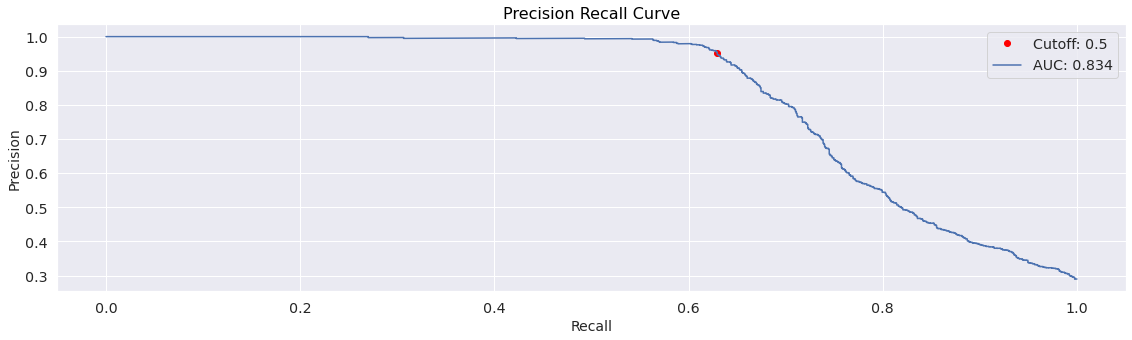

In [110]:
utils.show_preci_recal(predi, y_predi_data, cutof)

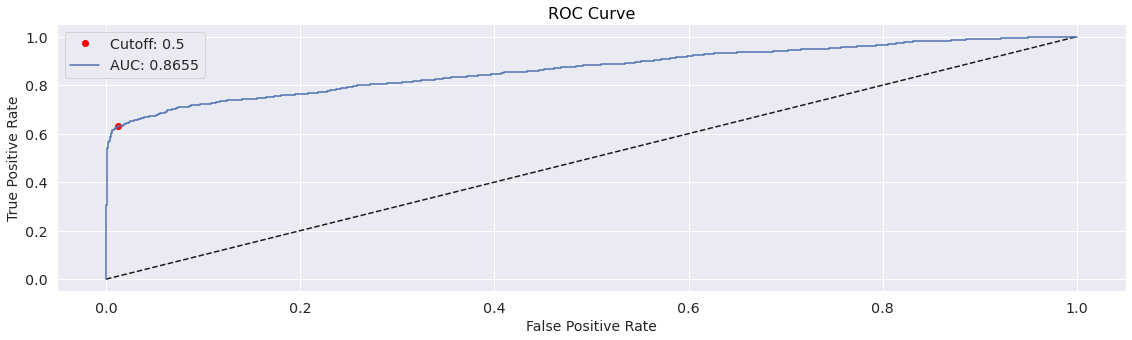

In [109]:
utils.show_roc(predi, y_predi_data, cutof)

In [107]:
importlib.reload(utils);

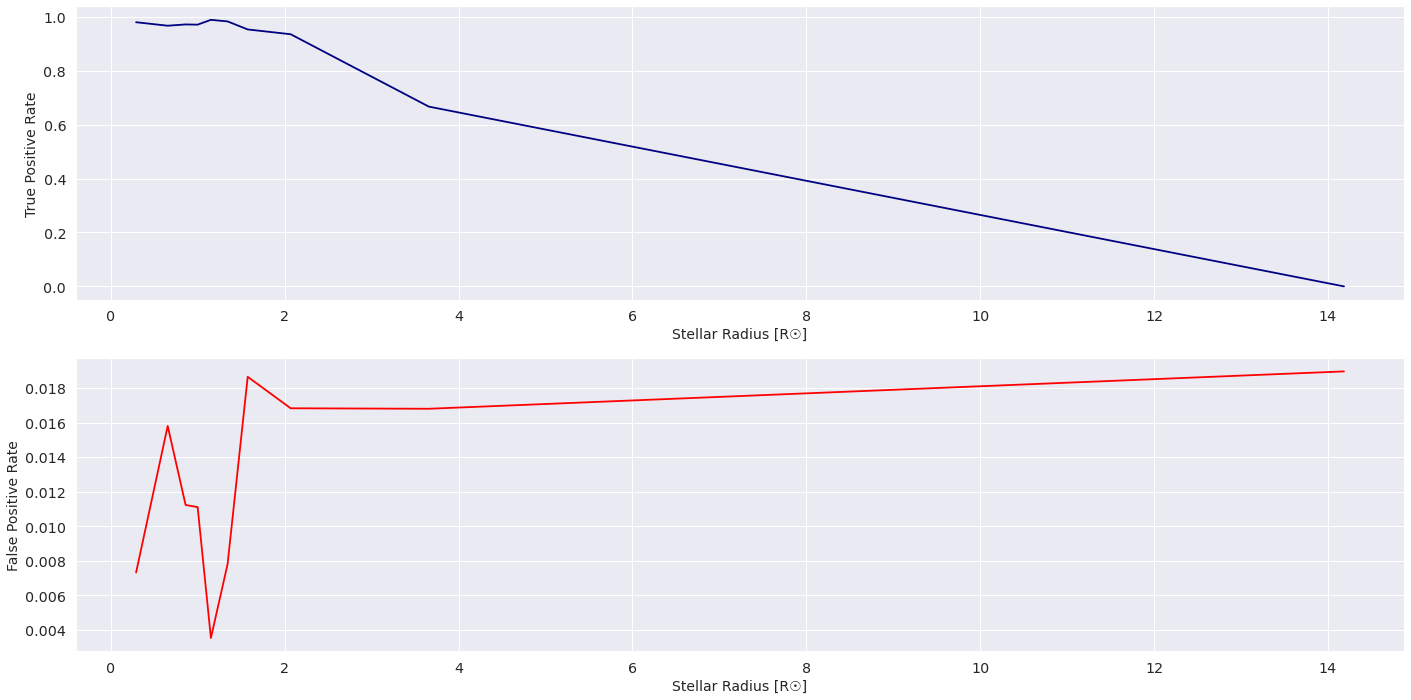

In [108]:
utils.show_tpr_fpr(x_full_predi_data, predi, cutof, 'stell_radiu', 10, False)

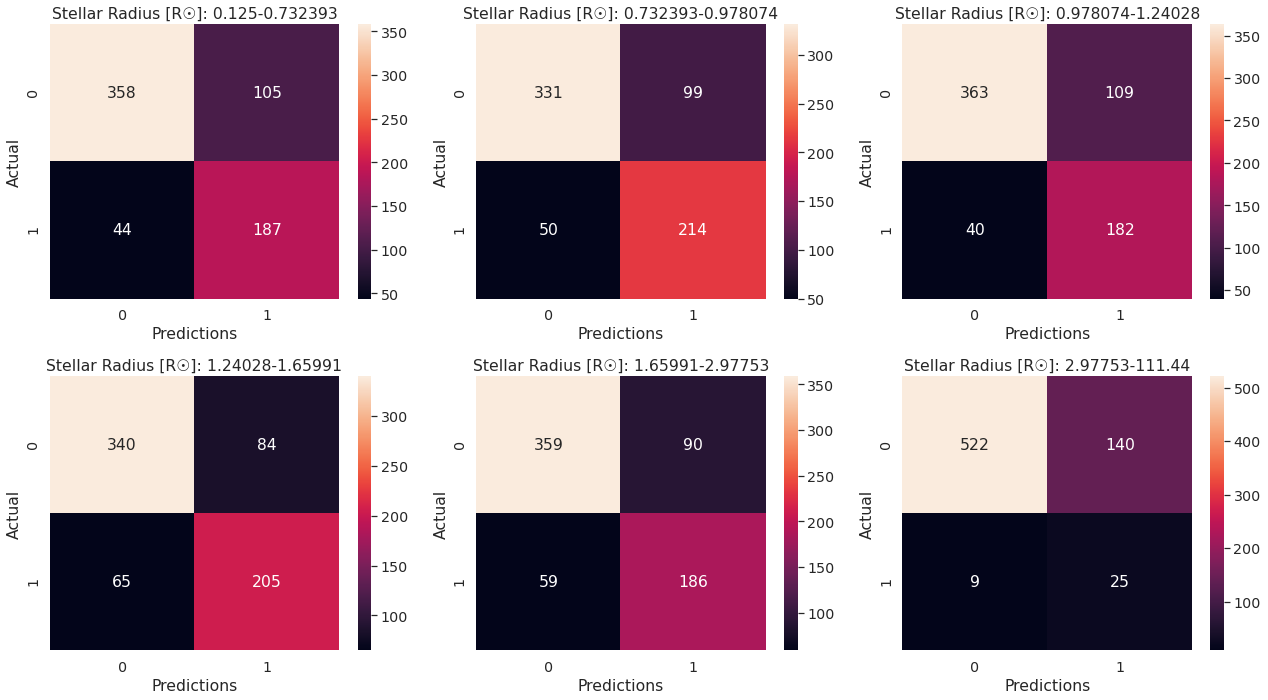

In [112]:
utils.show_confu_matri(x_full_predi_data, predi, cutof, 'stell_radiu', 6)

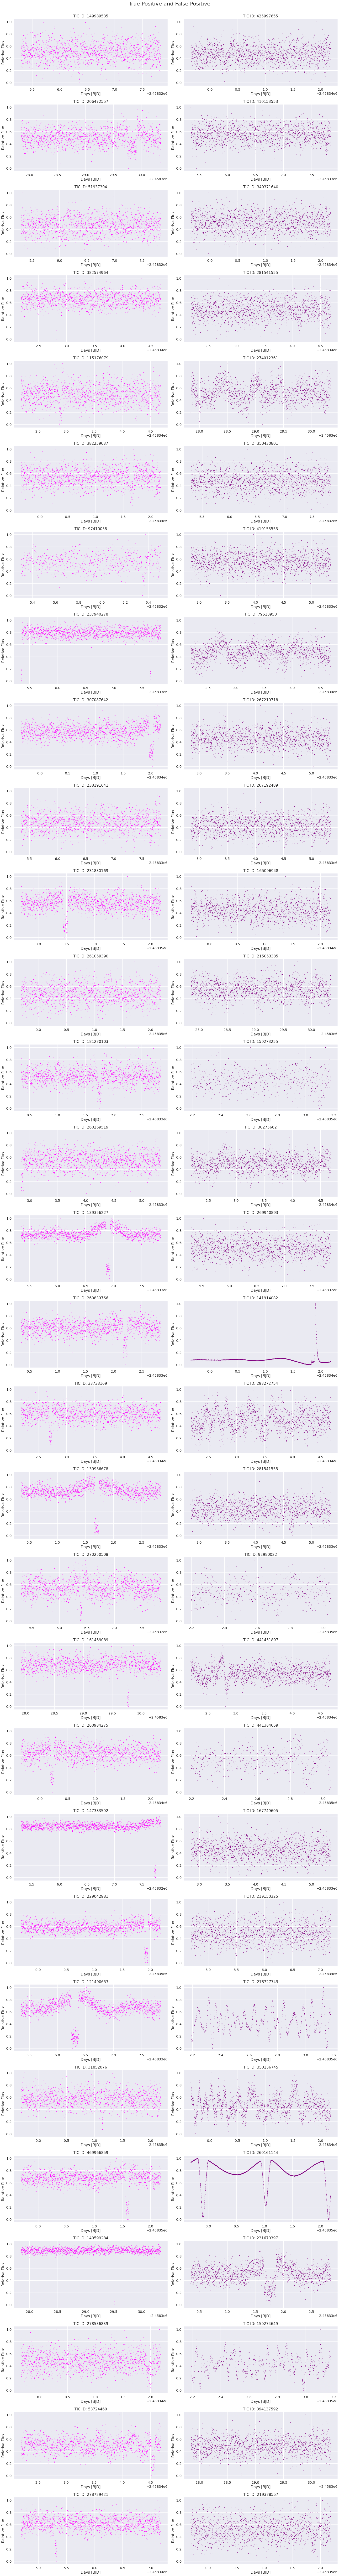

In [71]:
utils.show_predi_compa(x_full_predi_data, predi, cutof, [0,30], 'posit')

#### Formatting

In [22]:
forma = \
'''
initi = True
tuner = kt.BayesianOptimization(
    hypermodel = tuner_model,
    objective = 'val_accuracy',
    max_trials = 15,
    executions_per_trial = 1,
    distribution_strategy = mirror_strat,
    directory=log_direc,
    project_name ='Exomoon RNN')
'''
forma_done = FormatCode(forma, style_config='PEP8')
print(forma_done[0])

initi = True
tuner = kt.BayesianOptimization(hypermodel=tuner_model,
                                objective='val_accuracy',
                                max_trials=15,
                                executions_per_trial=1,
                                distribution_strategy=mirror_strat,
                                directory=log_direc,
                                project_name='Exomoon RNN')

